In [1]:
import numpy as np
from pathlib import Path
from scipy.stats import linregress
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold


## This part is for data preparation, after we have saved diff_result.csv, we can skip this part

In [11]:
# 读取Excel文件
# file_path = '../TE_analysefile_for_Tahereh_zijde.xlsx'
file_path = "../../data/TE_TreatmentResponse_cleanforJingnan.xlsx"

df = pd.read_excel(file_path)

# 移除 "SCANdatum" 和 "Scoredatum" 列
columns_to_remove = ['SCANdatum', 'Scoredatum', 'VISDATUM']
df = df.drop(columns=columns_to_remove)

remove_ls = [365, 387, 399, 458]  # these patients have no second scans

# 根据条件将 DataFrame 拆分为两个
condition = df['TENR'].isin(remove_ls)
df_no_second_scan = df[condition]
df = df[~condition]

placebo_df = df[df['treatment'] == 0]
df = df[df['treatment'] == 1]

# 提取所有有baseline的患者
baseline_df = df[df['VISNUMMER'] == 1]

# 提取所有有second的患者
second_df = df[df['VISNUMMER'] != 1]


In [18]:
# 合并两个数据框，基于ID进行对齐
merged_df = pd.merge(baseline_df, second_df, on='TENR', suffixes=('_baseline', '_12month'), how='inner').copy()

# 计算second的临床数据减去baseline的临床数据
result_df = merged_df.copy()
clinical_columns = [i for i in df.columns if 'tot' in i.lower()]  
clinical_columns_baseline = [i + '_baseline' for i in clinical_columns] #
clinical_columns_12month = [i + '_12month' for i in clinical_columns] #

# merged_df_clean = merged_df[clinical_columns_baseline + clinical_columns_12month]
# merged_df_clean.dropna()

for column in clinical_columns:
    merged_df[column + '_diff'] = merged_df[column + '_12month'] - merged_df[column + '_baseline']

# 选择需要保存的列
result_columns = ['TENR'] + clinical_columns_baseline + clinical_columns_12month + [column + '_diff' for column in clinical_columns]

# 保存结果为新的Excel文件
result_df = merged_df[result_columns].copy()
result_df.rename(columns={'TENR': 'ID'}, inplace=True)
result_df.dropna(inplace=True)
result_df.to_excel('../../data/diff_result_3.xlsx', index=False)
result_df.to_csv('../../data/diff_result_3.csv', index=False)

## This part is for data analysis

In [2]:
result_df = pd.read_csv('../../data/diff_result_3.csv')

In [3]:
filtered_df = result_df

In [57]:
def analysis(category, threshold_baseline):
    print(f"start category: {category} with threshold of {threshold_baseline}")
    baseline_name = 'Tot_' + category + '_baseline'
    diff_name = baseline_name.replace('baseline', 'diff')
    diff_pred_name = diff_name + '_pred'
    diff_bin_name = diff_name + '_bin'
    diff_pred_fold_name = diff_pred_name + '_fold'  # the prediction in this fold
    
    
    # 提取 x 和 y 列
    x = filtered_df[baseline_name]
    y = filtered_df[diff_name]
    slope, intercept, r_value, p_value, std_err = linregress(x, y) # 计算线性回归
    filtered_df[diff_pred_name] = slope * x + intercept  # 计算预测值
    R = np.corrcoef(x, y)[0, 1]  # 计算皮尔逊相关系数
    
    # 创建 Tot_baseline_bin 列
    filtered_df[diff_bin_name] = np.where(filtered_df[diff_name] < threshold_baseline, 0, 1)

    # 新增一列用于存储预测值
    filtered_df[diff_pred_fold_name] = np.nan

    # 分成4折
    folds = 3
    kf = KFold(n_splits=folds, shuffle=True, random_state=711)

    # 存储每折的结果
    roc_auc_list = []
    roc_auc_list_train = []
    max_f1_values = []
    max_f1_values_train = []
    sensitivity_ls = []
    precision_ls = []

    for fold, (train_index, test_index) in enumerate(kf.split(filtered_df)):
        print(f"------fold {fold+1}----")
        train_data = filtered_df.iloc[train_index]
        test_data = filtered_df.iloc[test_index]

        # 训练模型（使用线性回归，你也可以替换为其他模型）
        x_train = train_data[baseline_name]
        y_train = train_data[diff_name]
        # print(x_train.shape, y_train.shape)
    
        # 在训练集上进行预测
        print('----start training ... ----')
        
        model = np.polyfit(x_train.squeeze(), y_train, 1)
        slope, intercept, r_value, p_value, std_err = linregress(x_train, y_train) # 计算线性回归
        slope2 = model[0]
        intercept2 = model[1]
        print(f'slope_train: {slope:.2f}, intercept_train: {intercept:.2f}, r_value_train: {r_value:.2f}')


        print(x_train.shape, y_train.shape)

        y_pred_train = np.polyval(model, x_train.squeeze())
        # 保存预测值到 result_df 中
        filtered_df.iloc[train_index, filtered_df.columns.get_loc(diff_pred_fold_name)] = y_pred_train

        # 计算 ROC 曲线和 AUC 值
        fpr, tpr, thresholds = roc_curve(train_data[diff_bin_name], y_pred_train)
        roc_auc = auc(fpr, tpr)
        roc_auc_list_train.append(roc_auc)


        matrix = confusion_matrix(train_data[diff_bin_name], y_pred_train > threshold_baseline)
        print('confusion_matrix', matrix)
        # f1_train= f1_score(train_data[diff_bin_name], y_pred_train > threshold_baseline)
        # max_f1_values_train.append(f1_train)

        # 打印每折的结果
        print(f"ROC AUC 值：{roc_auc:.2f}")
        print('----end training ... ----')

        
        
        # 在测试集上进行预测
        print('----start testing ... ----')

        x_test = test_data[[baseline_name]].squeeze()
        y_test = test_data[diff_name]
        
        print(x_test.shape, y_test.shape)
        # slope, intercept, r_value, p_value, std_err = linregress(x_test, y_test) # 计算线性回归
        # print('slope_test, intercept_test, r_value_test', slope, intercept, r_value)


        y_pred_test = np.polyval(model, x_test.squeeze())
        # 保存预测值到 result_df 中
        filtered_df.iloc[test_index, filtered_df.columns.get_loc(diff_pred_fold_name)] = y_pred_test

        # 计算 ROC 曲线和 AUC 值
        fpr, tpr, thresholds = roc_curve(test_data[diff_bin_name], y_pred_test)
        roc_auc = auc(fpr, tpr)
        roc_auc_list.append(roc_auc)

        matrix = confusion_matrix(test_data[diff_bin_name], y_pred_test > threshold_baseline)
        print('confusion_matrix', matrix)

        # f1_test= f1_score(test_data[diff_bin_name], y_pred_test > threshold_baseline)
        # max_f1_values.append(f1_test)

        # 打印每折的结果
        print(f"Testing data set: ROC AUC 值：{roc_auc:.2f}")
        
        
        
            # 绘制 预测散点图
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.6))
        ax1.scatter(x_test, y_test, color='black', s=10)
        # print(x_test.to_numpy())
        # print('---')
        # print(y_pred)
        # break
        min_idx = np.argmin(x_test.to_numpy())
        max_idx = np.argmax(x_test.to_numpy())
        ax1.set_xlabel('baseline')
        ax1.set_ylabel('score diff label')
        ax1.set_xlim(0, max(filtered_df[baseline_name]))
        ax1.set_ylim(min(filtered_df[diff_name]), max(filtered_df[diff_name]))
        ax1.axhline(y=threshold_baseline, color='grey', linestyle='--', label=f'y = {threshold_baseline}')
        ax1.plot([x_test.to_numpy()[min_idx], x_test.to_numpy()[max_idx]], [y_pred_test[min_idx], y_pred_test[max_idx]], color='navy', lw=1, linestyle='--')
        x_cross_value = (threshold_baseline - intercept)/slope
        print(f"x_cross_value = {x_cross_value}")
        ax1.axvline(x=x_cross_value, color='grey', linestyle='--', label=f'y = {x_cross_value}')
        ax1.axvline(x=-threshold_baseline, color='grey', linestyle='--', label=f'y = {threshold_baseline}')


        ax1.plot(x_test.to_numpy(), x_test.to_numpy() * slope + intercept, color='navy', lw=1, linestyle='--')

        # scatter = ax2.scatter(y_pred, y_test, color='blue', s=10)
        # 绘制横线y=-3.12
        ax2.axhline(y=threshold_baseline, color='grey', linestyle='--', label=f'y = {threshold_baseline}')
        # 绘制竖线x=-3.12
        ax2.axvline(x=threshold_baseline, color='grey', linestyle='--', label=f'x = {threshold_baseline}')

        # ax2.yaxis.set_label_position('right')
        ax2.set_ylabel('score diff label')
        ax2.set_xlabel('score diff pred')  
        
        # 获取x轴和y轴的最大最小值
        xy_min, xy_max = min(filtered_df[diff_name]), max(filtered_df[diff_name])


        # 设置x轴和y轴的最大最小值一致
        ax2.set_xlim(xy_min, xy_max)
        ax2.set_ylim(xy_min, xy_max)

        # 划分四个区域的数据点
        TN_data = (y_pred_test > threshold_baseline) & (y_test > threshold_baseline)
        FP_data = (y_pred_test < threshold_baseline) & (y_test > threshold_baseline)
        FN_data = (y_pred_test > threshold_baseline) & (y_test < threshold_baseline)
        TP_data = (y_pred_test < threshold_baseline) & (y_test < threshold_baseline)

        # 统计每个区域的数据点个数
        TN = sum(TN_data)
        FN = sum(FN_data)
        FP = sum(FP_data)
        TP = sum(TP_data)
        
        sensitivity = TP / (TP + FN)
        precision = TP / (TP + FP)
        sensitivity_ls.append(sensitivity)
        precision_ls.append(precision)
        f1 = 2 * TP / (2 * TP + FP + FN)
        specificity = TN / (FP + TN)
        # print('two f1: ', f1, f1_test)s
        # 在图中标注每个区域的数据点个数
        ax2.text(xy_max * 0.6, xy_max * 0.8, f'TN: {TN}', ha='center', va='center', fontsize=12, color='blue')
        ax2.text(xy_min * 0.8, xy_max * 0.8, f'FP: {FP}', ha='center', va='center', fontsize=12, color='red')
        ax2.text(xy_max * 0.6, xy_min * 0.9, f'FN: {FN}', ha='center', va='center', fontsize=12, color='darkorange')
        ax2.text(xy_min * 0.8, xy_min * 0.9, f'TP: {TP}', ha='center', va='center', fontsize=12, color='green')

        x_baseline_min = 0
        x_baseline_max = max(x_test)
        ax1.text(x_baseline_max * 0.9, xy_max * 0.8, f'FP: {FP}', ha='center', va='center', fontsize=12, color='red')
        ax1.text(x_baseline_max * 0.2, xy_max * 0.8, f'TN: {TN}', ha='center', va='center', fontsize=12, color='blue')
        ax1.text(x_baseline_max * 0.9, xy_min * 0.9, f'TP: {TP}', ha='center', va='center', fontsize=12, color='green')
        ax1.text(x_baseline_max * 0.2, xy_min * 0.9, f'FN: {FN}', ha='center', va='center', fontsize=12, color='darkorange')

        # ax2.text(xy_min * 0.6, xy_max * 0.6, f'F1={f1:.2f}', ha='center', va='center', fontsize=12, color='black')
        # ax2.set_title)

        # 在散点图中分别绘制四个区域的数据点，并使用不同颜色
        ax2.scatter(y_pred_test[TN_data], y_test[TN_data], color='blue', s=10, label='Top Right')
        ax2.scatter(y_pred_test[FN_data], y_test[FN_data], color='darkorange', s=10, label='Top Left')
        ax2.scatter(y_pred_test[FP_data], y_test[FP_data], color='red', s=10, label='Bottom Right')
        ax2.scatter(y_pred_test[TP_data], y_test[TP_data], color='green', s=10, label='Bottom Left')
        ax2.set_title(f'F1={f1:.2f}, Sensitivity (recall, true positive rate)={sensitivity:.2f}, Precision={precision:.2f}, Specificity (true negative rate)={specificity:.2f}, AUC={roc_auc:.2f}', ha='center', fontsize=12)


        # 绘制 ROC 曲线
        # plt.figure(figsize=(2, 2))
        ax3.plot(fpr, tpr, color='black', lw=2, label='(area = {:.2f})'.format(roc_auc))
        # ax3.text(max(fpr) * 0.8, min(tpr) * 0.9, f'AUC={roc_auc:.2f}', ha='center', va='center', fontsize=12, color='black')

        ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax3.set_xlabel('False Positive Rate')
        # ax3.yaxis.set_label_position('right')
        ax3.set_ylabel('True Positive Rate')
        # ax3.set_title(f'ROC Curve (AUC={roc_auc:.2f})')
        plt.subplots_adjust(right=1.2)

        # plt.legend(loc='lower right')
        plt.suptitle(f'{category}. Fold {fold+1} / {folds} (validation data).', fontsize=16, y=1.05)

        plt.show()

    # 绘制散点图和回归线
    plt.figure(figsize=(6, 6))
    plt.scatter(filtered_df[diff_name], filtered_df[diff_pred_fold_name], label='实际值', alpha=0.5)
    # 绘制横线y=-3.12
    plt.axhline(y=threshold_baseline, color='grey', linestyle='--', label=f'y = {threshold_baseline}')

    # 绘制竖线x=-3.12
    plt.axvline(x=threshold_baseline, color='grey', linestyle='--', label=f'x = {threshold_baseline}')

    plt.xlabel(diff_name)
    plt.ylabel(diff_pred_fold_name)
    plt.title(f'{folds}-fold cross-validation result')
    # plt.legend()
    # 设置 x 和 y 轴上下限相同
    max_limit = max(filtered_df[diff_name].max(), filtered_df[diff_pred_fold_name].max())
    min_limit = min(filtered_df[diff_name].min(), filtered_df[diff_pred_fold_name].min())
    plt.xlim(min_limit, max_limit)
    plt.ylim(min_limit, max_limit)
    plt.show()

    # 打印平均结果
    print("\nMean AUC: {:.2f}".format(np.mean(roc_auc_list)))
    print("Mean F1: {:.2f}".format(np.mean(max_f1_values)))
    print(f"Mean sensitivity: {np.mean(sensitivity_ls):.2f}")
    print(f"Mean precision: {np.mean(precision_ls):.2f}")


In [60]:
filtered_df.to_excel('../../data/diff_result_4.xlsx', index=False)

start category: BME with threshold of -1.44
------fold 1----
----start training ... ----
slope_train: -0.42, intercept_train: 0.47, r_value_train: -0.55
(76,) (76,)
confusion_matrix [[ 3  9]
 [ 0 64]]
ROC AUC 值：0.95
----end training ... ----
----start testing ... ----
(39,) (39,)
confusion_matrix [[ 2  8]
 [ 0 29]]
Testing data set: ROC AUC 值：0.93
x_cross_value = 4.547026996402367


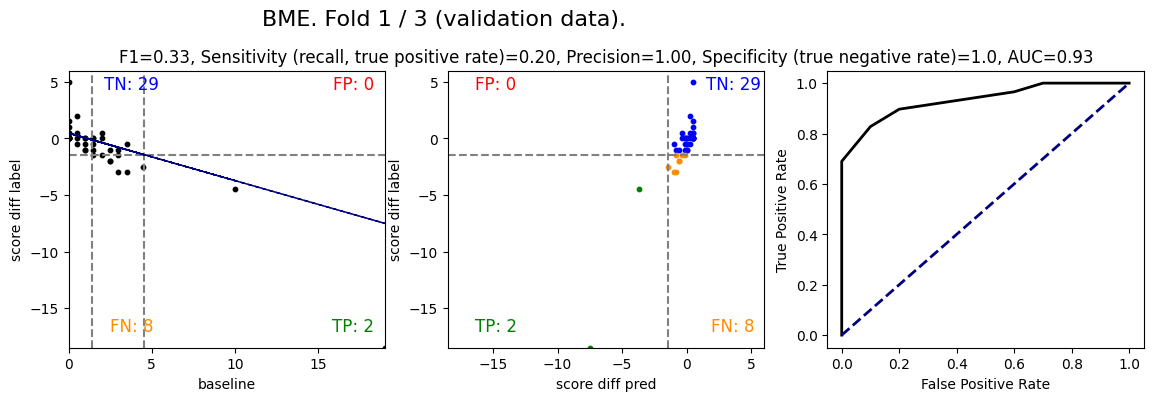

------fold 2----
----start training ... ----
slope_train: -0.85, intercept_train: 0.92, r_value_train: -0.87
(77,) (77,)
confusion_matrix [[11  4]
 [ 5 57]]
ROC AUC 值：0.94
----end training ... ----
----start testing ... ----
(38,) (38,)
confusion_matrix [[ 5  2]
 [ 4 27]]
Testing data set: ROC AUC 值：0.92
x_cross_value = 2.779987445072192


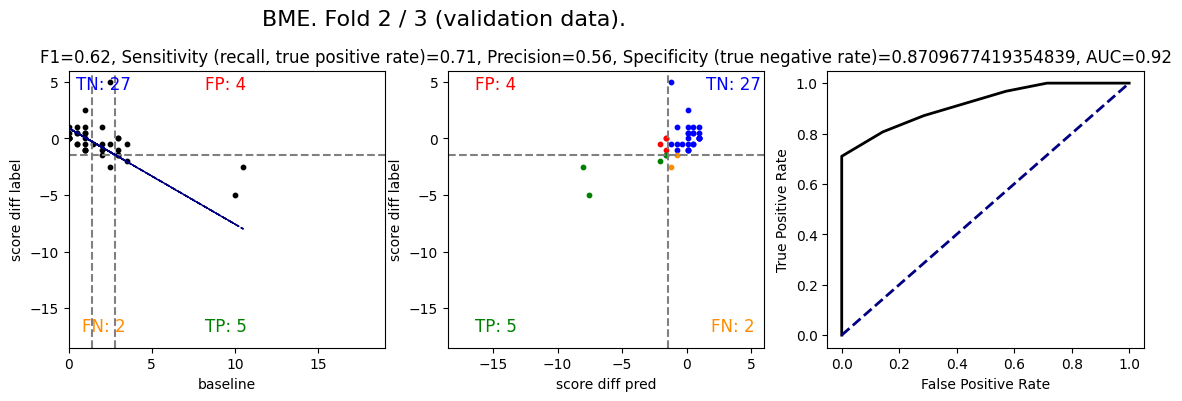

------fold 3----
----start training ... ----
slope_train: -0.74, intercept_train: 0.83, r_value_train: -0.83
(77,) (77,)
confusion_matrix [[ 7 10]
 [ 2 58]]
ROC AUC 值：0.92
----end training ... ----
----start testing ... ----
(38,) (38,)
confusion_matrix [[ 4  1]
 [ 1 32]]
Testing data set: ROC AUC 值：0.98
x_cross_value = 3.0516825762255033


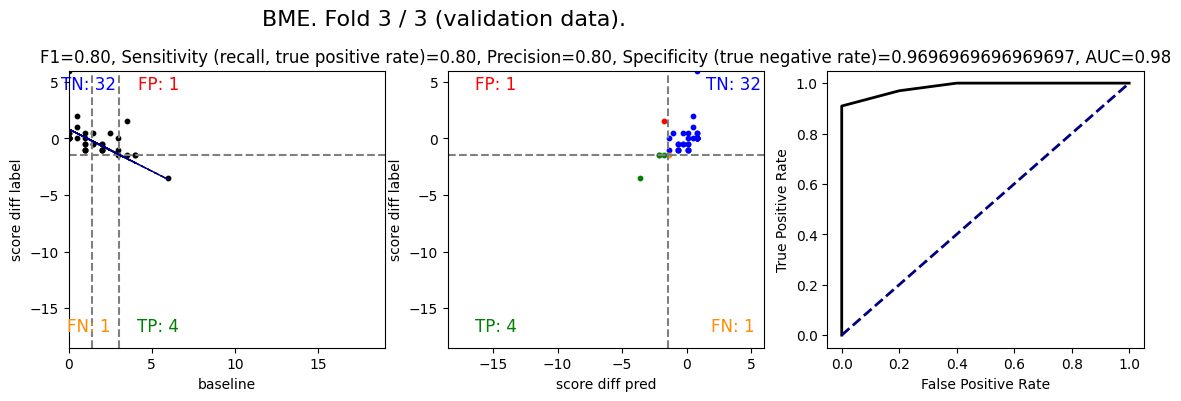

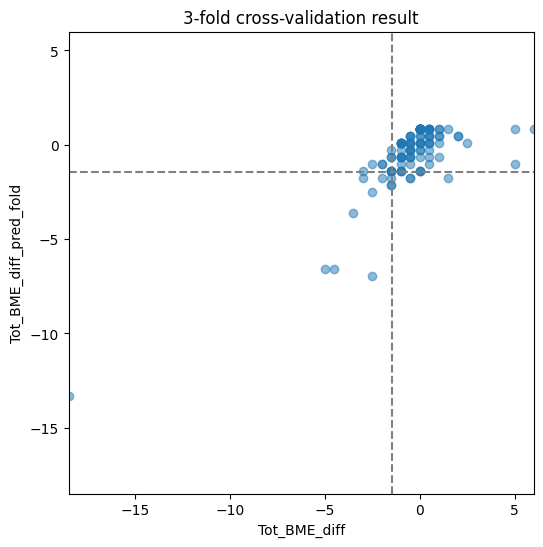


Mean AUC: 0.94
Mean F1: nan
Mean sensitivity: 0.57
Mean precision: 0.79
start category: SYN with threshold of -1.62
------fold 1----
----start training ... ----
slope_train: -0.41, intercept_train: 0.86, r_value_train: -0.49
(76,) (76,)
confusion_matrix [[ 4  9]
 [ 2 61]]
ROC AUC 值：0.85
----end training ... ----
----start testing ... ----
(39,) (39,)
confusion_matrix [[ 2  6]
 [ 1 30]]
Testing data set: ROC AUC 值：0.82
x_cross_value = 5.984208144796379


/home/jjia/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jjia/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


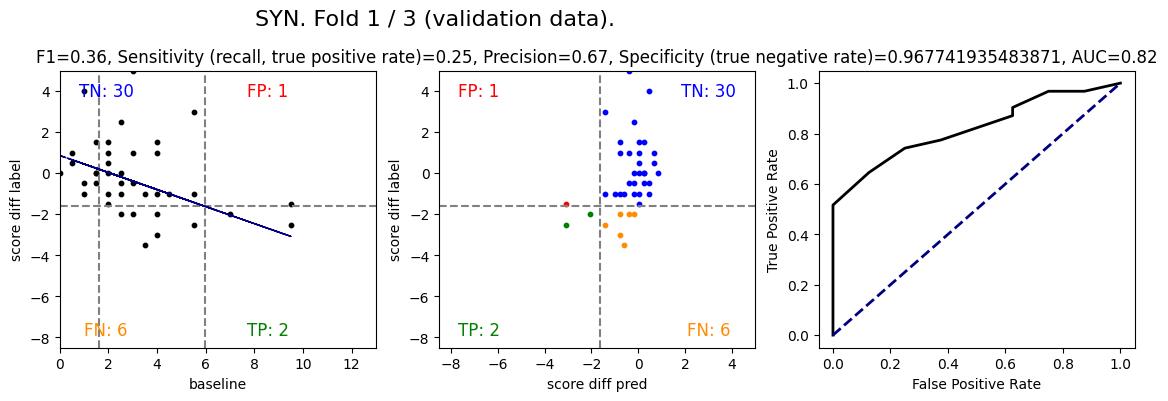

------fold 2----
----start training ... ----
slope_train: -0.45, intercept_train: 1.03, r_value_train: -0.51
(77,) (77,)
confusion_matrix [[ 5  9]
 [ 2 61]]
ROC AUC 值：0.83
----end training ... ----
----start testing ... ----
(38,) (38,)
confusion_matrix [[ 1  6]
 [ 1 30]]
Testing data set: ROC AUC 值：0.84
x_cross_value = 5.829901478889866


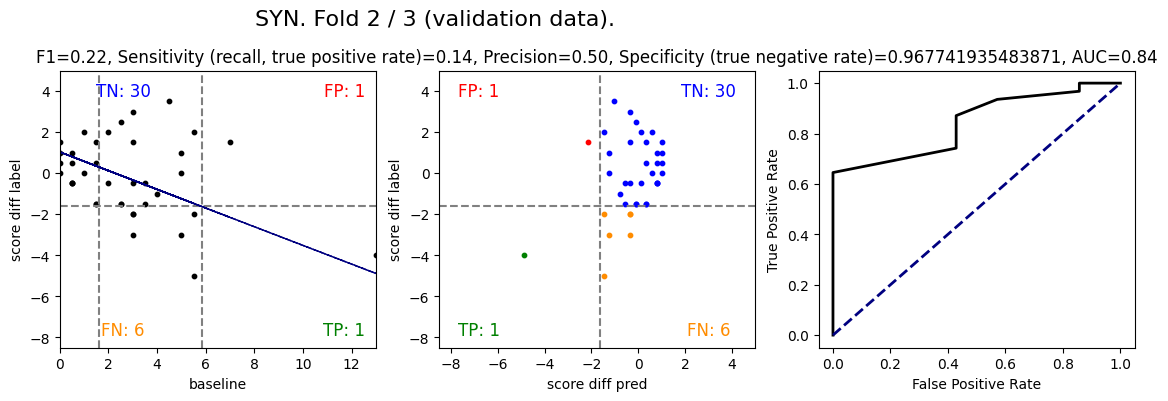

------fold 3----
----start training ... ----
slope_train: -0.27, intercept_train: 0.62, r_value_train: -0.34
(77,) (77,)
confusion_matrix [[ 2 13]
 [ 1 61]]
ROC AUC 值：0.83
----end training ... ----
----start testing ... ----
(38,) (38,)
confusion_matrix [[ 1  5]
 [ 0 32]]
Testing data set: ROC AUC 值：0.83
x_cross_value = 8.182072716862296


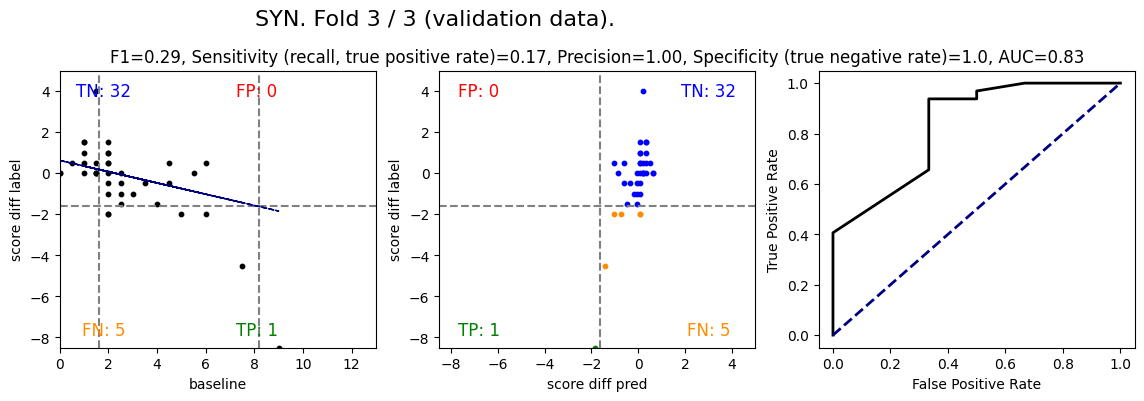

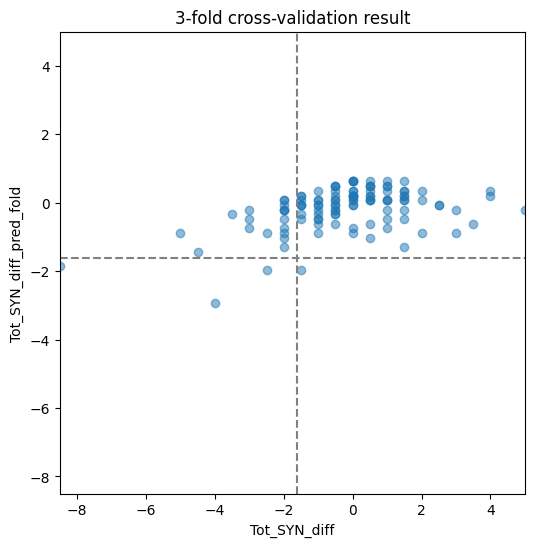


Mean AUC: 0.83
Mean F1: nan
Mean sensitivity: 0.19
Mean precision: 0.72
start category: TS with threshold of -1.63
------fold 1----
----start training ... ----
slope_train: -0.61, intercept_train: 0.49, r_value_train: -0.72
(76,) (76,)
confusion_matrix [[ 9  4]
 [ 4 59]]
ROC AUC 值：0.94
----end training ... ----
----start testing ... ----
(39,) (39,)
confusion_matrix [[10  1]
 [ 3 25]]
Testing data set: ROC AUC 值：0.97
x_cross_value = 3.459680195965025


/home/jjia/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jjia/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


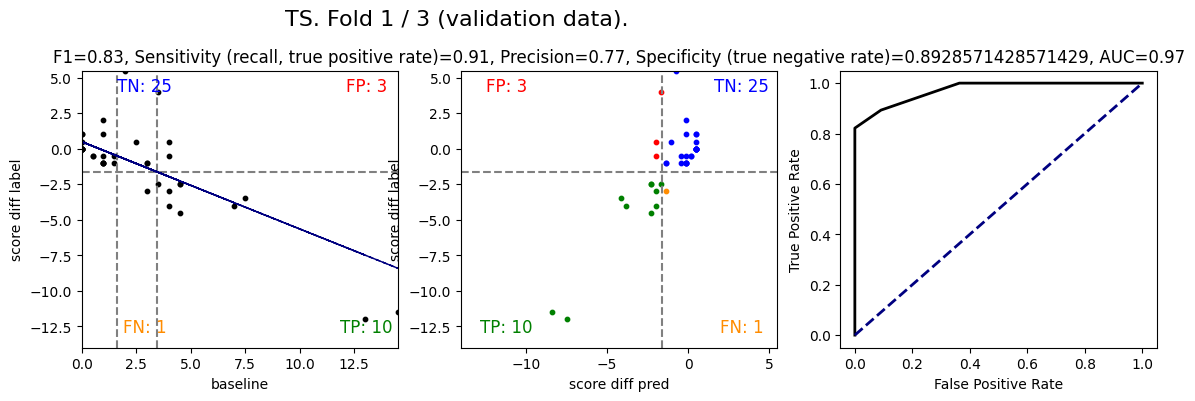

------fold 2----
----start training ... ----
slope_train: -0.78, intercept_train: 0.85, r_value_train: -0.81
(77,) (77,)
confusion_matrix [[14  4]
 [ 5 54]]
ROC AUC 值：0.94
----end training ... ----
----start testing ... ----
(38,) (38,)
confusion_matrix [[ 5  1]
 [ 2 30]]
Testing data set: ROC AUC 值：0.96
x_cross_value = 3.1786440401901594


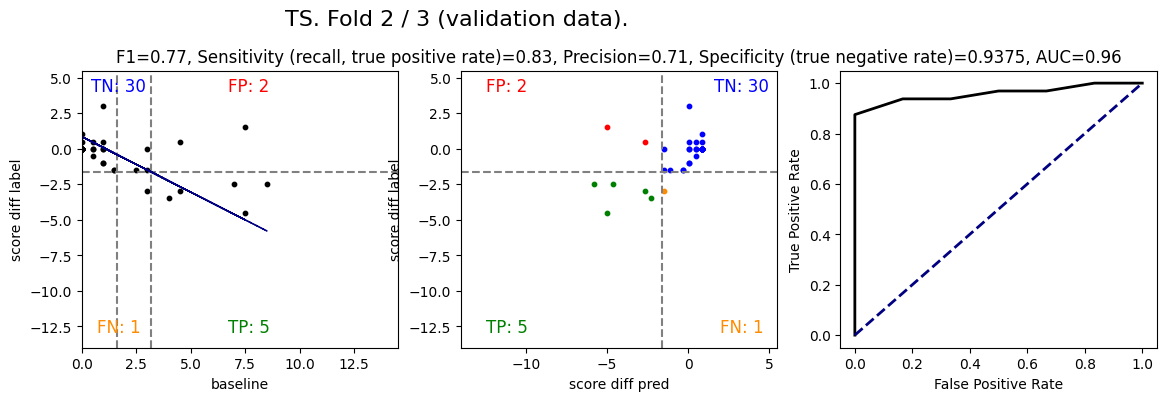

------fold 3----
----start training ... ----
slope_train: -0.63, intercept_train: 0.53, r_value_train: -0.74
(77,) (77,)
confusion_matrix [[15  2]
 [ 5 55]]
ROC AUC 值：0.96
----end training ... ----
----start testing ... ----
(38,) (38,)
confusion_matrix [[ 4  3]
 [ 2 29]]
Testing data set: ROC AUC 值：0.92
x_cross_value = 3.4034390801687087


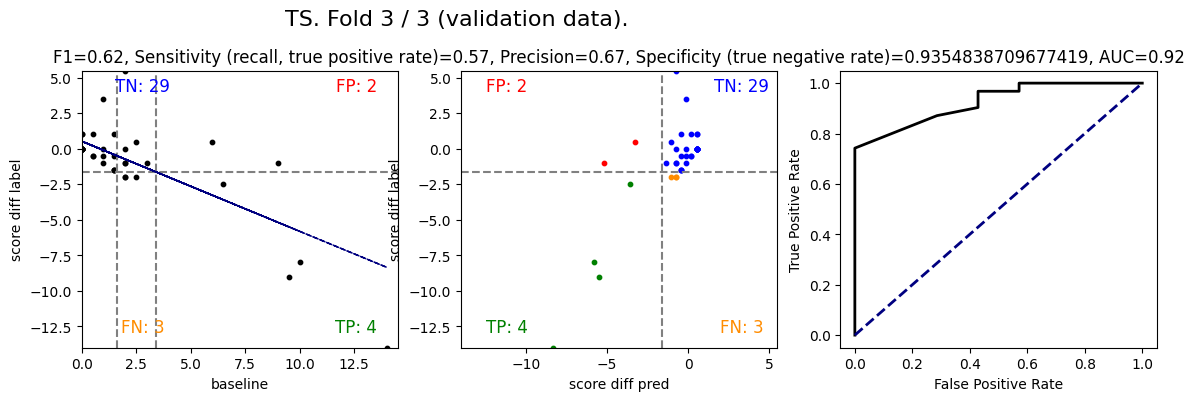

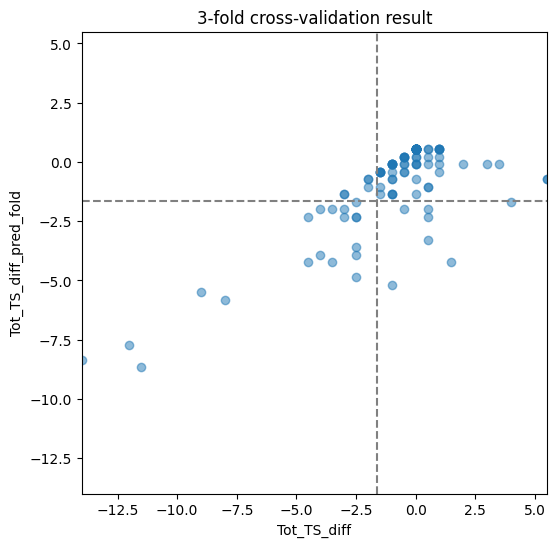


Mean AUC: 0.95
Mean F1: nan
Mean sensitivity: 0.77
Mean precision: 0.72
start category: inflammation with threshold of -3.07
------fold 1----
----start training ... ----
slope_train: -0.46, intercept_train: 1.72, r_value_train: -0.57
(76,) (76,)
confusion_matrix [[ 7  7]
 [ 3 59]]
ROC AUC 值：0.88
----end training ... ----
----start testing ... ----
(39,) (39,)
confusion_matrix [[ 7  7]
 [ 0 25]]
Testing data set: ROC AUC 值：0.95
x_cross_value = 10.3480493001932


/home/jjia/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jjia/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


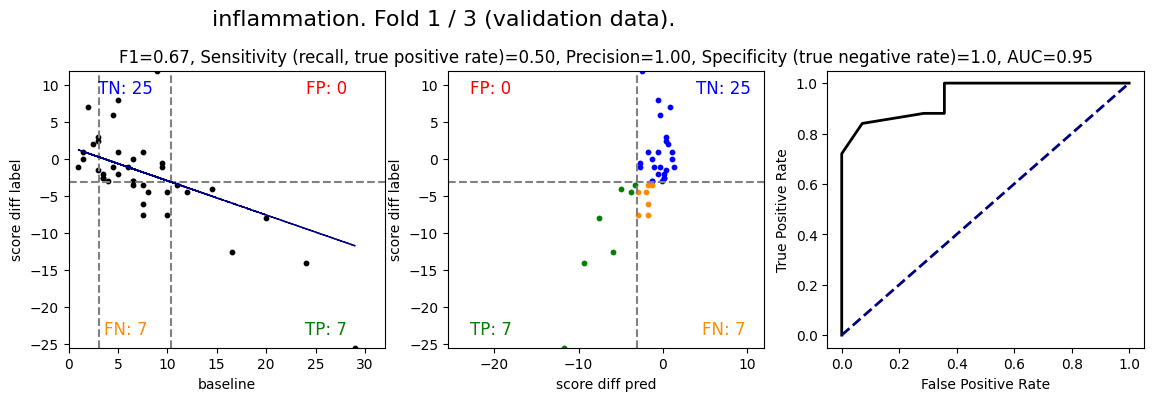

------fold 2----
----start training ... ----
slope_train: -0.78, intercept_train: 3.65, r_value_train: -0.76
(77,) (77,)
confusion_matrix [[13  7]
 [10 47]]
ROC AUC 值：0.90
----end training ... ----
----start testing ... ----
(38,) (38,)
confusion_matrix [[ 5  3]
 [ 3 27]]
Testing data set: ROC AUC 值：0.92
x_cross_value = 8.570567898846795


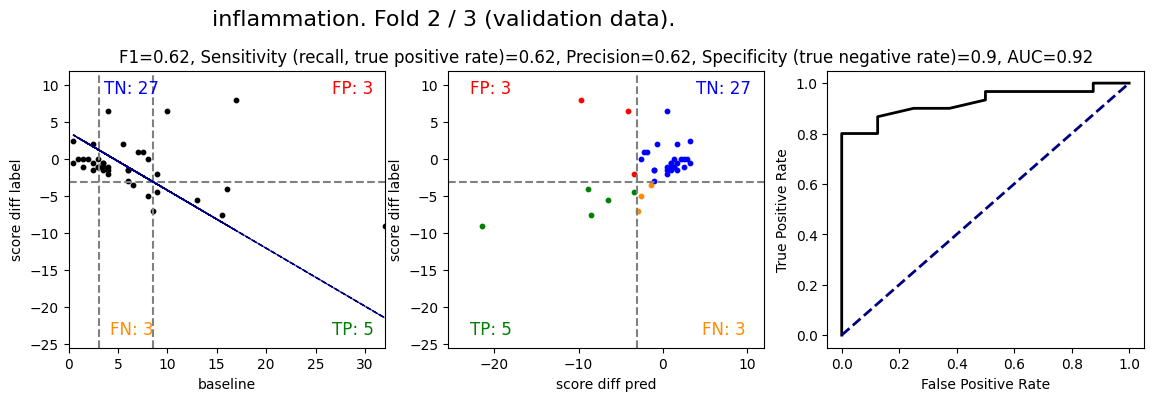

------fold 3----
----start training ... ----
slope_train: -0.52, intercept_train: 2.00, r_value_train: -0.61
(77,) (77,)
confusion_matrix [[13  9]
 [ 2 53]]
ROC AUC 值：0.93
----end training ... ----
----start testing ... ----
(38,) (38,)
confusion_matrix [[ 3  3]
 [ 5 27]]
Testing data set: ROC AUC 值：0.84
x_cross_value = 9.819489546293687


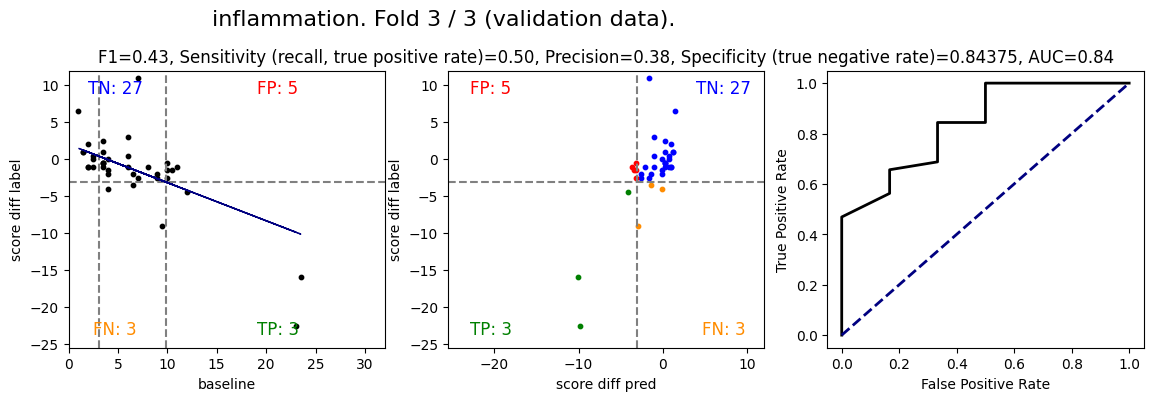

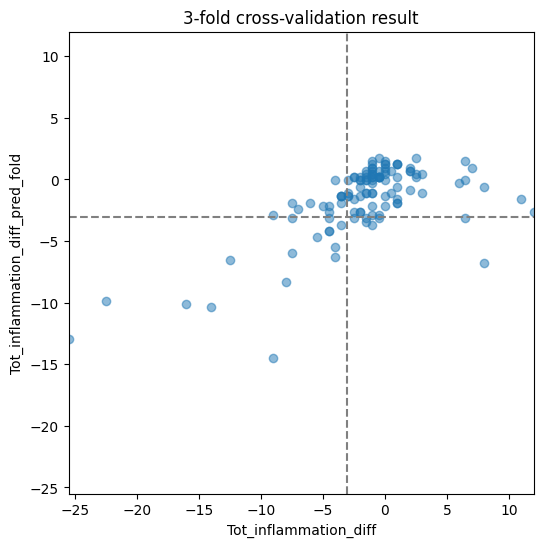


Mean AUC: 0.90
Mean F1: nan
Mean sensitivity: 0.54
Mean precision: 0.67


/home/jjia/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jjia/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [58]:
all_threshold_dt = {'BME': -1.44, 'SYN': -1.62, 'TS': -1.63, 'inflammation': -3.07}
for category, threshold in all_threshold_dt.items():
    analysis(category, threshold)